In [ ]:
# https://docs.classiq.io/latest/explore/algorithms/qml/qgan/qgan_bars_and_strips/#23-performance-evaluation

In [1]:
import time

import numpy as np


# Function to create Bars and Stripes dataset
def create_bars_and_stripes_dataset(num_samples):
    samples = []
    for _ in range(num_samples):
        horizontal = np.random.randint(0, 2) == 0
        if horizontal:
            stripe = np.random.randint(0, 2, size=(2, 1))
            sample = np.tile(stripe, (1, 2))
        else:
            stripe = np.random.randint(0, 2, size=(1, 2))
            sample = np.tile(stripe, (2, 1))
        samples.append(sample)
    return np.array(samples, dtype=np.uint8)

In [2]:
# Generate Bars and Stripes dataset
dataset = create_bars_and_stripes_dataset(num_samples=1000)

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# Plot images in a 3 by 3 grid
def plot_nine_images(generated_images):
    # Define custom colormap
    classiq_cmap = LinearSegmentedColormap.from_list(
        "teal_white", [(0, "#00FF00"), (1, "black")]
    )
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(2, 2), cmap=classiq_cmap, vmin=0, vmax=1)
        ax.axis("off")
        ax.set_title(f"Image {i+1}")
        for j in range(2):
            for k in range(2):
                label = int(generated_images[i].reshape(2, 2)[j, k])
                ax.text(
                    k,
                    j,
                    f"{label}",
                    ha="center",
                    va="center",
                    color="white" if label == 1 else "black",
                    fontsize=16,
                )
    plt.tight_layout()
    plt.show()

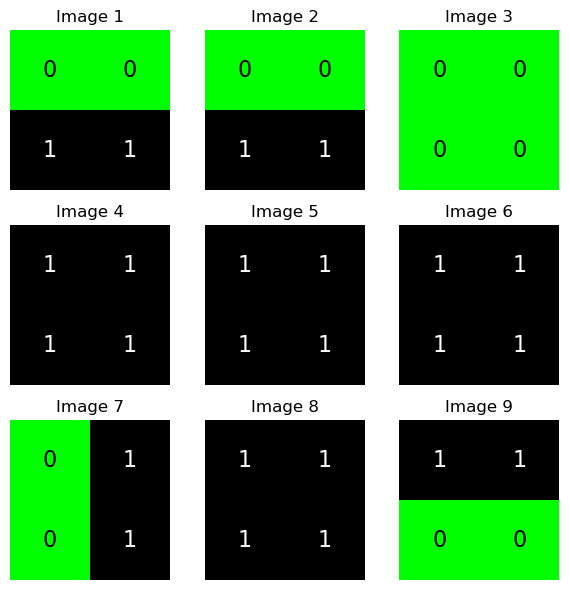

In [4]:
# Generate images
generated_images = create_bars_and_stripes_dataset(9)
plot_nine_images(generated_images)

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoader for training
tensor_dataset = TensorDataset(torch.tensor(dataset, dtype=torch.float))
dataloader = DataLoader(tensor_dataset, batch_size=64, shuffle=True)

In [6]:
import pathlib

path = (
    pathlib.Path(__file__).parent.resolve()
    if "__file__" in locals()
    else pathlib.Path(".")
)

In [7]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, input_size=2, output_size=4, hidden_size=32):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size // 2),  # Adjusted hidden layer size
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size),  # Adjusted hidden layer size
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid(),  # Sigmoid activation to output probabilities
        )

    def forward(self, x):
        return torch.round(self.model(x))


class Discriminator(nn.Module):
    def __init__(self, input_size=4, hidden_size=16):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size // 2),  # Adjusted hidden layer size
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size // 2, hidden_size),  # Adjusted hidden layer size
            nn.LeakyReLU(0.25),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(),  # Sigmoid activation to output probabilities
        )

    def forward(self, x):
        x = x.view(-1, 4)  # Flatten input for fully connected layers
        return self.model(x)

In [8]:
import os
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter


def train_gan(
    generator,
    discriminator,
    dataloader,
    log_dir_name,
    fixed_noise,
    random_fake_data_generator,
    num_epochs=100,
    device="cpu",
):

    # Initialize TensorBoard writer
    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = os.path.join(log_dir_name, run_id)
    writer = SummaryWriter(log_dir=log_dir)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

    generator.to(device)
    discriminator.to(device)

    for epoch in range(num_epochs):
        for i, batch in enumerate(dataloader):
            real_data = batch[0].to(device)
            batch_size = real_data.size(0)

            # Train Discriminator with real data
            d_optimizer.zero_grad()
            real_output = discriminator(real_data)
            d_real_loss = criterion(real_output, torch.ones_like(real_output))
            d_real_loss.backward()

            # Train Discriminator with fake data
            z = random_fake_data_generator(batch_size)
            fake_data = generator(z)
            fake_output = discriminator(fake_data.detach())
            d_fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
            d_fake_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            z = random_fake_data_generator(batch_size)
            fake_data = generator(z)
            fake_output = discriminator(fake_data)
            g_loss = criterion(fake_output, torch.ones_like(fake_output))
            g_loss.backward()
            g_optimizer.step()

            # Log losses to TensorBoard
            step = epoch * len(dataloader) + i
            writer.add_scalar("Generator Loss", g_loss.item(), step)
            writer.add_scalar("Discriminator Real Loss", d_real_loss.item(), step)
            writer.add_scalar("Discriminator Fake Loss", d_fake_loss.item(), step)

            if i % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                    f"Generator Loss: {g_loss.item():.4f}, "
                    f"Discriminator Real Loss: {d_real_loss.item():.4f}, "
                    f"Discriminator Fake Loss: {d_fake_loss.item():.4f}"
                )

        # Generate and log sample images for visualization
        # if (epoch+1) % (num_epochs // 10) == 0:
        #     with torch.no_grad():
        #         generated_images = generator(fixed_noise).detach().cpu()
        #     img_grid = vutils.make_grid(generated_images, nrow=3, normalize=True)
        #     writer.add_image('Generated Images', img_grid, epoch+1)

    # Close TensorBoard writer
    writer.close()

In [9]:
# Fixed noise for visualizing generated samples
fixed_noise = torch.randn(9, 2)


def random_fake_data_for_gan(batch_size, input_size):
    return torch.randn(batch_size, input_size)

In [10]:
generator = Generator(input_size=2, output_size=4, hidden_size=32)
discriminator = Discriminator(input_size=4, hidden_size=16)

# For simplicitly we load a pretrained model
# checkpoint = torch.load(path / "resources/generator_trained_model.pth")
# generator.load_state_dict(checkpoint)

train_gan(
    generator=generator,
    discriminator=discriminator,
    dataloader=dataloader,
    log_dir_name="logs",
    fixed_noise=fixed_noise,
    random_fake_data_generator=lambda b_size: random_fake_data_for_gan(b_size, 2),
    num_epochs=10,
    device="cpu",
)

# Save trained generator model
torch.save(generator.state_dict(),  "resources/generator_model.pth")

Epoch [1/10], Step [1/16], Generator Loss: 0.9999, Discriminator Real Loss: 0.8944, Discriminator Fake Loss: 0.4717
Epoch [2/10], Step [1/16], Generator Loss: 0.9867, Discriminator Real Loss: 0.8902, Discriminator Fake Loss: 0.4873
Epoch [3/10], Step [1/16], Generator Loss: 0.9996, Discriminator Real Loss: 0.8886, Discriminator Fake Loss: 0.4900
Epoch [4/10], Step [1/16], Generator Loss: 0.9526, Discriminator Real Loss: 0.8873, Discriminator Fake Loss: 0.5000
Epoch [5/10], Step [1/16], Generator Loss: 0.9625, Discriminator Real Loss: 0.8686, Discriminator Fake Loss: 0.5044
Epoch [6/10], Step [1/16], Generator Loss: 0.9616, Discriminator Real Loss: 0.8893, Discriminator Fake Loss: 0.4742
Epoch [7/10], Step [1/16], Generator Loss: 0.9709, Discriminator Real Loss: 0.8552, Discriminator Fake Loss: 0.4989
Epoch [8/10], Step [1/16], Generator Loss: 0.9641, Discriminator Real Loss: 0.8544, Discriminator Fake Loss: 0.4711
Epoch [9/10], Step [1/16], Generator Loss: 0.9467, Discriminator Real Lo

In [11]:
# Load state dictionary with mismatched sizes
generator = Generator()
checkpoint = torch.load( "resources/generator_model.pth")
generator.load_state_dict(checkpoint)
num_samples = 100
z = random_fake_data_for_gan(num_samples, 2)
gen_data = generator(z)


def evaluate_generator(samples):
    count_err = 0
    for img in samples:
        img = img.reshape(2, 2)
        diag1 = int(img[0, 0]) * int(img[1, 1])
        diag2 = int(img[0, 1]) * (int(img[1, 0]))
        if (diag1 == 1 or diag2 == 1) and diag1 * diag2 != 1:
            count_err += 1
    return (samples.shape[0] - count_err) / samples.shape[0]


accuracy = evaluate_generator(samples=gen_data)
print(f"Classically trained generator accuracy: {accuracy:.2%}%")

Classically trained generator accuracy: 85.00%%


/tmp/ipykernel_4135/2323115705.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load( "resources/generator_model.pth")


/tmp/ipykernel_4135/3425549298.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(path / "resources/generator_model.pth")


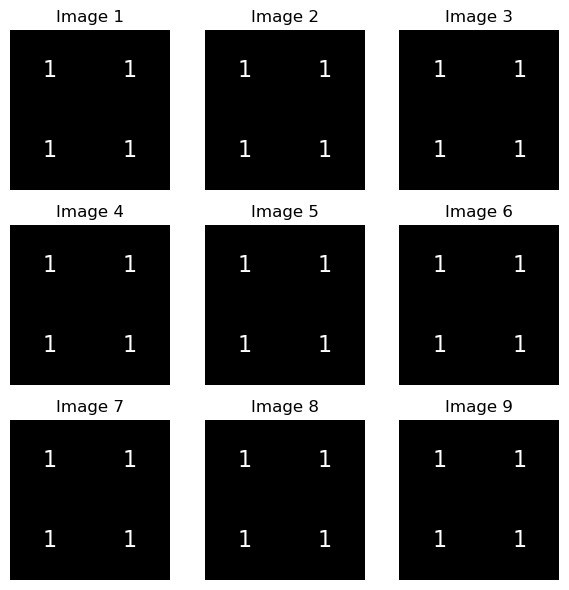

In [14]:
# Initialize generator for evaluation
generator_for_evaluation = Generator(input_size=2, output_size=4)
generator_for_evaluation.load_state_dict(
    torch.load(path / "resources/generator_model.pth")
)  # Load trained model
generator_for_evaluation.eval()

# Generate images
with torch.no_grad():
    noise = torch.randn(9, 2)
    generated_images = generator_for_evaluation(noise).detach().cpu().numpy()

# Plot images in a 3 by 3 grid
# generated_images = create_bars_and_stripes_dataset(9)
plot_nine_images(generated_images)